In [1]:
from pyproj import crs #import packages
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
import mapclassify
import numpy as np
import contextily as ctx
%matplotlib inline
from folium.plugins import HeatMap

In [2]:
grid_fp = "data/Glasgow.shp" # read in grid of Glasgow
grid = gpd.read_file(grid_fp)

roads_fp = "data/Roads.shp" #read in roads of glasgow
roads = gpd.read_file(roads_fp)

stations_fp = "data/Rail.shp" #read in train station stops in glasgow 
stations = gpd.read_file(stations_fp)

motorway_fp = "data/Motorway.shp" #read in train station stops in glasgow 
motorway= gpd.read_file(motorway_fp)

In [3]:
grid = grid.to_crs(epsg=3857) # converting crs
roads = roads.to_crs(crs=grid.crs)
stations = stations.to_crs(crs=grid.crs)
motorway = motorway.to_crs(crs=grid.crs)
roads.crs == stations.crs == grid.crs == motorway.crs

True

In [4]:
grid = grid.replace(-1, np.nan) #replace -1 data as nan calues
grid = grid.dropna() # drop the na values

In [5]:
grid = grid.rename(columns={'Rankv2': 'M_Deprivation_Rank'}) #rename column being used later

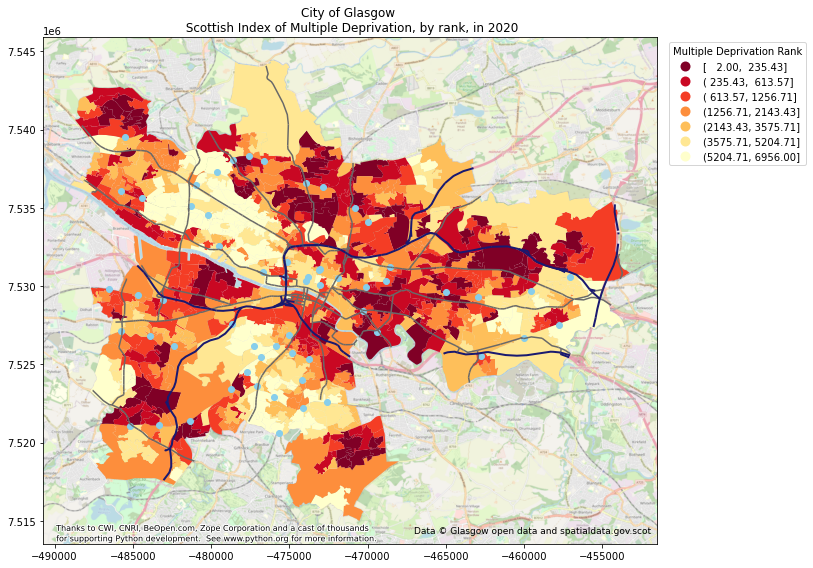

In [6]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="M_Deprivation_Rank", cmap="YlOrRd_r", linewidth=0, scheme="quantiles", k=7, legend =True)

# Add a roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="dimgrey", linewidth=1.5)

# Add rail stations on top of the previous map
motorway.plot(ax=ax, color="midnightblue", linewidth=2)

# Add rail stations on top of the previous map
stations.plot(ax=ax, color="skyblue")

# # Add basemap 
ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, alpha =0.8)

#Add title 
ax.set(title='City of Glasgow \n Scottish Index of Multiple Deprivation, by rank, in 2020')

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.25,1))
ax.get_legend().set_title("Multiple Deprivation Rank")

# #Add data source
plt.annotate('Data © Glasgow open data and spatialdata.gov.scot', xy=((-467000, 7514200)), size=9)

# Remove the empty white-space around the axes
plt.tight_layout()

#Save the map
outfp = "docs/static_map.png"
plt.savefig(outfp, dpi=300)

In [7]:
route_fp = "data/National_Cycle_Network.shp" # read Edinburgh cycle path
route = gpd.read_file(route_fp)

parking_fp = "data/Cycle_Parking.shp" #reading in Edinburgh cycle parking 
parking = gpd.read_file(parking_fp)

In [8]:
route = route.to_crs(epsg=3857) #check and change crs
parking = parking.to_crs(crs=route.crs)

In [9]:
parking_gjson = folium.features.GeoJson(parking, name="Public Bike Parking") #converting data to GeoJSON for map use
route_gjson = folium.features.GeoJson(route, name="Public Bike Routes")

In [10]:
# Get x and y coordinates for each point
locparking =gpd.GeoDataFrame(parking)
locparking = locparking.to_crs(epsg=4326)

locparking["x"] = locparking["geometry"].x
locparking["y"] = locparking["geometry"].y
                                

# Create a list of coordinate pairs
locations = list(zip(locparking["y"], locparking["x"]))

In [11]:
m = folium.Map(location=[55.953, -3.188], tiles = 'StamenTerrain', zoom_start=13, control_scale=True) #create folium map

route_gjson.add_to(m) #add bike roads

bpark = folium.GeoJson( #add points and extra data)
   parking,
   name = "Bike parking spots",
#    style_function= lambda x: {'color':'transparent','fillColor':'transparent','weight':0}, 
    tooltip=folium.features.GeoJsonTooltip(fields=['No_Spaces', 'Owned_by'],
                                             aliases = ['Number of bike spaces', 'Ownership'],
                                             labels=True,
                                             sticky=True)
)
bpark.add_to(m)
folium.LayerControl().add_to(m) # add layer control

outfp2 = "docs/interactive_map.html" #save map
m.save(outfp2)
m

In [12]:
#also wanted to make heatmap
m2 = folium.Map(location=[55.953, -3.188], tiles = 'StamenTerrain', zoom_start=13, control_scale=True) #added basemap
HeatMap(locations, name = 'Heatmap', radius =20, gradient = {0.4: '#571845', 0.65: '#C70039', 1: '#FFC300'}).add_to(m2) #added heat map and chnaged colours
route_gjson.add_to(m2) #added roads

folium.LayerControl().add_to(m2) #added layer control

outfp3 = "docs/interactive_map2.html" #save map
m2.save(outfp3)

m2

In [13]:
from folium.plugins import MarkerCluster # import cluster

m3 = folium.Map(location=[55.953, -3.188], tiles = 'StamenTerrain', zoom_start=13, control_scale=True) #added basemap

# Create a folium marker cluster
marker_cluster = MarkerCluster(locations, name= 'Clustermap')

# Add marker cluster to map
marker_cluster.add_to(m3)

route_gjson.add_to(m3) #added roads

folium.LayerControl().add_to(m3) #added layer control

outfp4 = "docs/interactive_map3.html"
m3.save(outfp4)

m3